# Final Project

## Table of Contents
- Load Data
- Feature Engineer
- Split Data
- Applied default algorithms
- Tune selected models
- Evaluate
- Try different concepts
- Conclusion

## Name (as it appears on Canvas)
----------





 Danh Nguyen

Research Question / Hypothesis
----
What health attribute would help to distinguish the presence (value 1) from absence (value 0) of heart disease?

In [ ]:
reset -fs

Load Data
-----

In [ ]:
%pip -q install category_encoders
%pip -q install pandas_profiling
%pip -q install base

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Imports

In [ ]:
from   category_encoders          import *
import numpy as np
import pandas as pd
from   sklearn.compose            import *
from   sklearn.ensemble           import RandomForestClassifier, ExtraTreesClassifier, IsolationForest
from   sklearn.experimental       import enable_iterative_imputer
from   sklearn.impute             import *
from   sklearn.linear_model       import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier
from   sklearn.metrics            import balanced_accuracy_score, roc_auc_score, f1_score # Evaluation metric 2.0 
from   sklearn.pipeline           import Pipeline
from   sklearn.preprocessing      import *
from   sklearn.tree               import DecisionTreeClassifier, ExtraTreeClassifier
from   sklearn.model_selection    import train_test_split
from   pandas_profiling           import ProfileReport
from   sklearn.model_selection    import RandomizedSearchCV
from   sklearn.svm                import LinearSVC
from   sklearn.base               import BaseEstimator
from   sklearn.decomposition      import PCA
from   sklearn.model_selection    import cross_val_score, cross_val_predict
from   sklearn.cluster            import KMeans
from   sklearn.metrics            import plot_confusion_matrix
from   sklearn.ensemble           import StackingClassifier
from   sklearn.pipeline           import make_pipeline



## Load Data

In [ ]:
data = pd.read_csv('heart.csv')
y = data['target']
X = data.drop('target', axis=1)

## Feature Engineering

In [ ]:
# Define 
num_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), 
                     ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [ ]:
# Preprocessing data - Note oldpeak has 33% of 0
preprocessing = ColumnTransformer([('numerical', num_pipe, ['age','trestbps','chol','thalach','oldpeak']),
                                   ('categorical', cat_pipe, ['sex','cp','fbs','restecg','exang','slope','ca','thal'])
                                   ])

Split Train, Validation, Test data
----

In [ ]:
# Split data and then don't touch test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
# Slit for train and validation data set
X_train_sub, X_validation, y_train_sub, y_validation = train_test_split(X_train, y_train, train_size=0.7)

## Try fitting multiple Sklearn algorithms

In [ ]:
# Selected high potential algorithms with default settings
algos = [RandomForestClassifier(),
        ExtraTreesClassifier(),
        IsolationForest(),
        LogisticRegression(),
        PassiveAggressiveClassifier(),
        RidgeClassifier(),
        SGDClassifier(),
        DecisionTreeClassifier(),
        ExtraTreeClassifier()]

In [ ]:
# For each algorithm, fit, predict, and evaluate with F1 score
for algo in algos:
    pipe = Pipeline([('preprocessing', preprocessing),
                    ('algo', algo)])
    pipe.fit(X_train_sub, y_train_sub)
    y_pred = pipe.predict(X_validation)
    auc_score = f1_score(y_pred, y_validation, average='weighted')
    print(f"{algo} : {auc_score}")

RandomForestClassifier() : 0.8760416666666666
ExtraTreesClassifier() : 0.8450520833333334
IsolationForest() : 0.29062499999999997
LogisticRegression() : 0.8304275019700552
PassiveAggressiveClassifier() : 0.84375
RidgeClassifier() : 0.8304275019700552
SGDClassifier() : 0.79766210281581
DecisionTreeClassifier() : 0.6762706855791963
ExtraTreeClassifier() : 0.733495670995671


In [ ]:
# Create a dummy estimator for random search
class DummyEstimator(BaseEstimator):
    """Pass through class, methods are present but do nothing."""
    def fit(self): pass
    def score(self): pass

pipe = Pipeline([('preprocessing', preprocessing),
                ('classifier', DummyEstimator())])

### Hyperperameter search
- LogisticRegression: penalty can shrink model parameters' coefficient for better performance, C can changed strengths of penalties, fit_intercept is to decide whether or not to include the intercept for lower error, class_weight is set for balanced or None, and Solver algorithm is for different optimization problems.
- RandomForestClassifier: criterion determines quality of split, n_estimators for number of trees in the forest, max_features is to consider how to split and select features, max_depth is for size of the trees, class_weight is for the weights associated to each class.
- ExtraTreesClassifier: same hyperperameters as RandomForestClassifier

In [ ]:
# Define search space for 3 algos and range of their hyperparameters

search_space = [{'classifier': [LogisticRegression()],
                'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                'classifier__C': np.logspace(0, 4, 10),
                'classifier__fit_intercept': [True, False],
                'classifier__class_weight': ['balanced','None'],
                'classifier__solver' : ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']},
                
               {'classifier': [RandomForestClassifier()],
                'classifier__criterion': ['gini', 'entropy'],
                'classifier__n_estimators': [50,100,150,200],
                'classifier__max_features': ['auto','sqrt','log2'],
                'classifier__max_depth': [20,50,100,200],
                'classifier__class_weight' : ['balanced','balanced_subsample']},
                
               {'classifier': [ExtraTreesClassifier()],
                'classifier__criterion': ['gini', 'entropy'],
                'classifier__n_estimators': [50,100,150,200],
                'classifier__max_features': ['auto','sqrt','log2'],
                'classifier__max_depth': [20,50,100,200],
                'classifier__class_weight' : ['balanced','balanced_subsample']}]

# Apply RandomizedSearch with pip and search space
clf_algos_rand = RandomizedSearchCV(estimator=pipe, 
                                   param_distributions=search_space, 
                                   n_iter=500,
                                   cv=5, 
                                   n_jobs=-1,
                                   verbose=1)

best_model = clf_algos_rand.fit(X_train_sub, y_train_sub)

best_model.best_estimator_.get_params()['classifier']

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.82528736 0.83908046        nan        nan        nan        nan
        nan        nan 0.80505747 0.80482759 0.83908046 0.80505747
 0.8183908         nan 0.81218391        nan 0.81862069        nan
 0.81862069        nan        nan 0.81195402 0.84551724 0.80551724
        nan 0.81862069 0.81172414 0.8183908         nan 0.81885057
 0.80528736 0.81885057 0.83218391        nan 0.80551724 0.81172414
 0.80482759 0.81172414 0.83218391        nan 0.83241379        nan
 0.85218391        nan        nan 0.80482759        nan 0.84551724
 0.83195402 0.79885057 0.82551724 0.82528736        nan 0.80482759
        nan 0.83885057 0.81885057        nan 0.79862069        nan
        nan 0.8183908  0.80482759        nan        nan        nan
 0.80482759 0.81264368 0.80482759 0.82574713 

ExtraTreesClassifier(class_weight='balanced_subsample', criterion='entropy',
                     max_depth=200, max_features='sqrt', n_estimators=200)

In [ ]:
# best model and it's hyperperamters
pipe = Pipeline([('clm',  ExtraTreesClassifier(class_weight='balanced',
                                                  criterion='entropy',
                                                  max_depth=200, 
                                                  max_features='log2',  
                                                  n_estimators=150))])

## Model Evaluation

In [ ]:
# ROC score on validaton set
pipe.fit(X_train_sub, y_train_sub)
y_pred = pipe.predict(X_validation)
roc_auc = roc_auc_score(y_pred, y_validation)
roc_auc

0.8208333333333333

In [ ]:
# F1 score on validaton set
y_pred = pipe.predict(X_validation)
f1_weighted_score = f1_score(y_pred, y_validation, average='weighted')
f1_weighted_score

0.8287910100749161

In [ ]:
# F1 score from cross validation - model get to see more data, better prediction accuracy
cv_f1_score = cross_val_score(pipe, X_train, y_train, cv=20,scoring='f1_weighted')
print("Mean 20-Fold f1 score: {}".format(np.mean(cv_f1_score)))

Mean 20-Fold f1 score: 0.8388708513708515


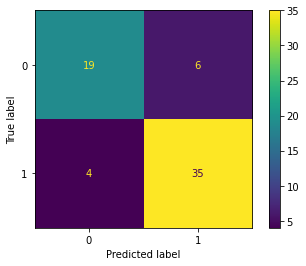

In [ ]:
# Confusion Matrix to see prediction outcomes
pipe.fit(X_train_sub, y_train_sub)
plot_confusion_matrix(pipe, X_validation, y_validation)

## Applying different concepts
- Feature engineer with PCA and K-mean clustering with best model
- Stack Models 

In [ ]:
# Apply PCA before k-mean clustering
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X) 
print(f"Original number of features: {X.shape[1]}")
print(f"Reduced number of features that retain 99% variance:  {X_pca.shape[1]}")

Original number of features: 13
Reduced number of features that retain 99% variance:  4


In [ ]:
# Use previous best algorithm with k-mean clustering in feature engineering
pipe = Pipeline([('pca', PCA(n_components=.99)), # found that 4 components retain 99% variance of y
                ('k-mean', KMeans(n_clusters=20)),
                ('scaler', StandardScaler()),
                ('clm',  ExtraTreesClassifier(class_weight='balanced_subsample',
                                                  criterion='entropy',
                                                  max_depth=100, 
                                                  max_features='log2',  
                                                  n_estimators=50))])

# F1 Score with cross validation for PCA, K-mean clustering, with best model and tune hyperparamters
# Not great for prediction, but better for interoperability
cv_f1_score = cross_val_score(pipe, X_train, y_train, cv=20,scoring='f1_weighted')
print("Mean 20-Fold f1 score: {}".format(np.mean(cv_f1_score)))

Mean 20-Fold f1 score: 0.6604179154179153


In [ ]:
# Stacking algorithms with default settings
estimators = [('passive_clf', ExtraTreesClassifier())]
clf_stacked = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())


In [ ]:
# Evaluation of stacked models
cv_f1_score = cross_val_score(clf_stacked, X_train, y_train, cv=20,scoring='f1_weighted')
print("Mean 20-Fold f1 score: {}".format(np.mean(cv_f1_score)))


Mean 20-Fold f1 score: 0.8286865911865913


## Conclusion
- For single model performance, ExtraTreesClassifier model perform best
- Cross validation is key to improve model training
- Stacked models has slightly more prediction power, at the cost of computation load
- Even though this data set is fairly small, I can still apply a good ML model to help detect a presence of heart disease. 
- I would select a simple working model over complexed models that might have little to no gain. Selected model listed below:

In [ ]:
# best single algorithm and it's hyperperamters
pipe = Pipeline([('clm',  ExtraTreesClassifier(class_weight='balanced',
                                                  criterion='entropy',
                                                  max_depth=200, 
                                                  max_features='log2',  
                                                  n_estimators=150))])

In [ ]:
# F1 score on test set
# fit model on the entire training data 
pipe.fit(X_train, y_train)

# predict and evaluate
y_pred = pipe.predict(X_test)
f1_weighted_score = f1_score(y_pred, y_test, average='weighted')
f1_weighted_score

0.7700125645679184

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=960ce66a-728d-4a49-9d4e-4ed93cf3dd63' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>